# adj_list = [relation1, relation2, relation3]

In [2]:
import scipy.sparse as sp
import numpy as np
from collections import defaultdict


# 随机生成一个10x10的邻接矩阵，其中非零元素的概率为0.3
adjacency_matrix_1 = np.random.choice([0, 1], size=(10, 10), p=[0.7, 0.3])
adjacency_matrix_1 = np.tril(adjacency_matrix_1) + np.tril(adjacency_matrix_1, -1).T
print(adjacency_matrix_1)
adjacency_matrix_2 = np.random.choice([0, 1], size=(10, 10), p=[0.7, 0.3])
adjacency_matrix_2 = np.tril(adjacency_matrix_2) + np.tril(adjacency_matrix_2, -1).T
adjacency_matrix_3 = np.random.choice([0, 1], size=(10, 10), p=[0.7, 0.3])
adjacency_matrix_3 = np.tril(adjacency_matrix_3) + np.tril(adjacency_matrix_3, -1).T

# 将邻接矩阵转换为稀疏矩阵格式
sparse_matrix_1 = sp.csr_matrix(adjacency_matrix_1)
sparse_matrix_2 = sp.csr_matrix(adjacency_matrix_2)
sparse_matrix_3 = sp.csr_matrix(adjacency_matrix_3)

temp_array = [sparse_matrix_1, sparse_matrix_2, sparse_matrix_3]
adj_lists = []

for relation in temp_array:
    homo_adj = relation + sp.eye(relation.shape[0])
    # create adj_list
    adj_li = defaultdict(set)
    edges = homo_adj.nonzero()
    for index, node in enumerate(edges[0]):
        adj_li[node].add(edges[1][index])
        adj_li[edges[1][index]].add(node)
    adj_lists.append(adj_li)

print(adj_lists)

[[0 0 0 1 0 0 1 0 0 1]
 [0 0 1 0 0 0 1 0 0 0]
 [0 1 1 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 1 1 1 0 0 0]]
[defaultdict(<class 'set'>, {0: {0, 9, 3, 6}, 3: {0, 8, 3, 6}, 6: {0, 1, 2, 3, 6, 9}, 9: {0, 4, 5, 6, 9}, 1: {1, 2, 6}, 2: {1, 2, 4, 6, 8}, 4: {9, 2, 4}, 8: {8, 2, 3}, 5: {9, 5}, 7: {7}}), defaultdict(<class 'set'>, {0: {0, 1, 5}, 1: {0, 1}, 5: {0, 2, 4, 5, 6, 9}, 2: {2, 3, 5}, 3: {8, 2, 3}, 8: {8, 9, 3, 6}, 4: {9, 4, 5, 6}, 6: {4, 5, 6, 7, 8}, 9: {4, 5, 7, 8, 9}, 7: {9, 6, 7}}), defaultdict(<class 'set'>, {0: {0, 3, 7}, 3: {0, 1, 3, 4, 8, 9}, 7: {0, 8, 5, 7}, 1: {1, 2, 3}, 2: {1, 2, 4}, 4: {2, 3, 4, 8, 9}, 8: {3, 4, 7, 8, 9}, 9: {3, 4, 5, 6, 8, 9}, 5: {9, 5, 7}, 6: {9, 6}})]


# InterAgg

## forward

In [3]:
to_neighs = []
nodes = [0, 1, 2]
# 对adj_list循环提取每一种关系，
for adj_list in adj_lists:
    to_neighs.append([set(adj_list[int(node)]) for node in nodes])

to_neighs

[[{0, 3, 6, 9}, {1, 2, 6}, {1, 2, 4, 6, 8}],
 [{0, 1, 5}, {0, 1}, {2, 3, 5}],
 [{0, 3, 7}, {1, 2, 3}, {1, 2, 4}]]

上述代码每一个元素都是一个关系的节点邻居

In [4]:
unique_nodes = set.union(set.union(*to_neighs[0]), set.union(*to_neighs[1]),
                         set.union(*to_neighs[2], set(nodes)))
unique_nodes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

返回所有邻居的节点标号（索引）

In [16]:
from scipy.sparse import csr_matrix
import torch.nn as nn
import torch
# 生成随机稀疏矩阵
num_nonzero = 160 # 指定非零元素个数
rows = np.random.randint(0, 10, size=num_nonzero) # 随机生成行索引
cols = np.random.randint(0, 32, size=num_nonzero) # 随机生成列索引
data = np.random.rand(num_nonzero) # 随机生成非零元素的值

# 创建稀疏矩阵
sparse_matrix = csr_matrix((data, (rows, cols)), shape=(10, 32))
feat_data = sparse_matrix.todense().A

def normalize(mx):
	"""
		Row-normalize sparse matrix
		Code from https://github.com/williamleif/graphsage-simple/
	"""
	rowsum = np.array(mx.sum(1)) + 0.01
	r_inv = np.power(rowsum, -1).flatten()
	r_inv[np.isinf(r_inv)] = 0.
	r_mat_inv = sp.diags(r_inv)
	mx = r_mat_inv.dot(mx)
	return mx

feat_data = normalize(feat_data)

# 打印稀疏矩阵
features = nn.Embedding(feat_data.shape[0], feat_data.shape[1])
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
features.weight

Parameter containing:
tensor([[0.1606, 0.2576, 0.0000, 0.0000, 0.0000, 0.0570, 0.0773, 0.0000, 0.0000,
         0.0000, 0.0637, 0.0000, 0.0000, 0.0277, 0.0000, 0.1578, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0000, 0.0000,
         0.1084, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0504, 0.0000, 0.0000, 0.0000, 0.1693, 0.0000, 0.0000, 0.0543,
         0.0000, 0.0586, 0.0310, 0.0000, 0.0715, 0.0694, 0.0565, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0777, 0.1792, 0.0270, 0.0000, 0.0148, 0.0000, 0.0000,
         0.0707, 0.0686, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0255, 0.0137, 0.1018, 0.1130, 0.0000,
         0.0000, 0.0000, 0.0082, 0.0000, 0.1112, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0642, 0.0000, 0.0000, 0.0517, 0.0000, 0.0000, 0.0000, 0.1323,
         0.0000, 0.0518, 0.3254, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1385, 0.0000, 0.0000, 0.0127, 0.0031, 0.0000, 0.1669,
         0.1657, 0

人造features

In [18]:
features.cuda()
batch_features = features(torch.cuda.LongTensor(list(unique_nodes)))
batch_features

tensor([[0.1606, 0.2576, 0.0000, 0.0000, 0.0000, 0.0570, 0.0773, 0.0000, 0.0000,
         0.0000, 0.0637, 0.0000, 0.0000, 0.0277, 0.0000, 0.1578, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0000, 0.0000,
         0.1084, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0504, 0.0000, 0.0000, 0.0000, 0.1693, 0.0000, 0.0000, 0.0543,
         0.0000, 0.0586, 0.0310, 0.0000, 0.0715, 0.0694, 0.0565, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0777, 0.1792, 0.0270, 0.0000, 0.0148, 0.0000, 0.0000,
         0.0707, 0.0686, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0255, 0.0137, 0.1018, 0.1130, 0.0000,
         0.0000, 0.0000, 0.0082, 0.0000, 0.1112, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0642, 0.0000, 0.0000, 0.0517, 0.0000, 0.0000, 0.0000, 0.1323,
         0.0000, 0.0518, 0.3254, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1385, 0.0000, 0.0000, 0.0127, 0.0031, 0.0000, 0.1669,
         0.1657, 0.0446, 0.0000, 0.0558,

提取所有unique_nodes的feature

将 batch_features输入Linear模型，输出形状为(batch_siez, 2)的tensor,计算出batch_scores

In [20]:
label_clf = nn.Linear(32, 2).cuda()
batch_scores = label_clf(batch_features)
batch_scores

tensor([[ 0.0517,  0.1103],
        [-0.0136,  0.0625],
        [ 0.0058,  0.0411],
        [-0.0035,  0.0136],
        [ 0.0155, -0.0098],
        [ 0.0342,  0.0119],
        [-0.0024,  0.0611],
        [ 0.0334,  0.0029],
        [ 0.0383,  0.0287],
        [ 0.0105,  0.0020]], device='cuda:0', grad_fn=<AddmmBackward0>)

计算出这个batch中所有出现的节点的label-aware分数

In [21]:
id_mapping = {node_id: index for node_id, index in zip(unique_nodes, range(len(unique_nodes)))}
id_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

创立一个映射表

In [47]:
from operator import itemgetter

center_scores = batch_scores[itemgetter(*nodes)(id_mapping), :]
center_scores

tensor([[ 0.0517,  0.1103],
        [-0.0136,  0.0625],
        [ 0.0058,  0.0411]], device='cuda:0', grad_fn=<IndexBackward0>)

提取出中心节点的label-aware分数

In [26]:
r1_list = [list(to_neigh) for to_neigh in to_neighs[0]]
r2_list = [list(to_neigh) for to_neigh in to_neighs[1]]
r3_list = [list(to_neigh) for to_neigh in to_neighs[2]]
print(r1_list)
print(r2_list)
print(r3_list)

[[0, 9, 3, 6], [1, 2, 6], [1, 2, 4, 6, 8]]
[[0, 1, 5], [0, 1], [2, 3, 5]]
[[0, 3, 7], [1, 2, 3], [1, 2, 4]]


获取邻居节点list

In [27]:
r1_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r1_list]
r2_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r2_list]
r3_scores = [batch_scores[itemgetter(*to_neigh)(id_mapping), :].view(-1, 2) for to_neigh in r3_list]
r1_scores

[tensor([[ 0.0517,  0.1103],
         [ 0.0105,  0.0020],
         [-0.0035,  0.0136],
         [-0.0024,  0.0611]], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[-0.0136,  0.0625],
         [ 0.0058,  0.0411],
         [-0.0024,  0.0611]], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[-0.0136,  0.0625],
         [ 0.0058,  0.0411],
         [ 0.0155, -0.0098],
         [-0.0024,  0.0611],
         [ 0.0383,  0.0287]], device='cuda:0', grad_fn=<ViewBackward0>)]

上面结果就是提取出r_1下每个中心节点邻居的label-aware分数

In [29]:
import math

thresholds = [0.5, 0.5, 0.5]

r1_sample_num_list = [math.ceil(len(neighs) * thresholds[0]) for neighs in r1_list]
r2_sample_num_list = [math.ceil(len(neighs) * thresholds[1]) for neighs in r2_list]
r3_sample_num_list = [math.ceil(len(neighs) * thresholds[2]) for neighs in r3_list]

r1_sample_num_list

[2, 2, 3]

2,2,3 分别是(4,3,5)/2向上取整，得到的过滤后的邻居个数，这里展示的是r_1

# IntraAgg

## init

In [ ]:
features = features
self.cuda = cuda
self.feat_dim = feat_dim

In [ ]:
# Eq. (8) in the paper
# 传入batch_nodes、[r1,r2,r3]_list、center_scores、[r1,r2,r3]_scores、[r1,r2,r3]_sample_num_list
r1_feats, r1_scores = self.intra_agg1.forward(nodes, r1_list, center_scores, r1_scores, r1_sample_num_list)
r2_feats, r2_scores = self.intra_agg2.forward(nodes, r2_list, center_scores, r2_scores, r2_sample_num_list)
r3_feats, r3_scores = self.intra_agg3.forward(nodes, r3_list, center_scores, r3_scores, r3_sample_num_list)

## forward

In [ ]:
# def forward(self, nodes, to_neighs_list, batch_scores, neigh_scores, sample_list):

# filer neighbors under given relation
# 给定关系下过滤后的邻居和分数
samp_neighs, samp_scores = filter_neighs_ada_threshold(batch_scores, neigh_scores, to_neighs_list, sample_list)

# find the unique nodes among batch nodes and the filtered neighbors
unique_nodes_list = list(set.union(*samp_neighs))
unique_nodes = {n: i for i, n in enumerate(unique_nodes_list)}

# intra-relation aggregation only with sampled neighbors
mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
row_indices = [i for i in range(len(samp_neighs)) for _ in range(len(samp_neighs[i]))]
mask[row_indices, column_indices] = 1
if self.cuda:
    mask = mask.cuda()
num_neigh = mask.sum(1, keepdim=True)
mask = mask.div(num_neigh)
if self.cuda:
    embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
else:
    embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
to_feats = mask.mm(embed_matrix)
to_feats = F.relu(to_feats)

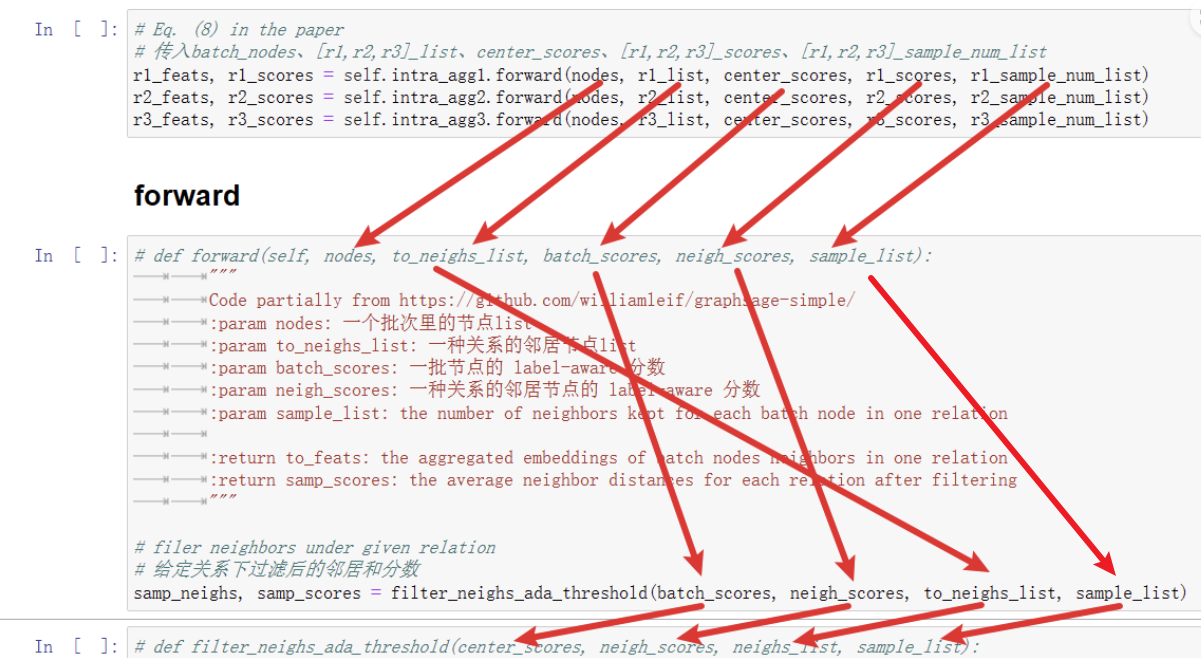

In [34]:
idx = 0
neigh_scores = r1_scores
neighs_list = r1_list
sample_list = r1_sample_num_list

center_score_r1 = center_scores[idx][0]
center_score_r1

tensor(0.0517, device='cuda:0', grad_fn=<SelectBackward0>)

以第一个循环为例，取出第一个中心节点的score的第一列

In [32]:
neigh_score = neigh_scores[idx][:, 0].view(-1, 1)
neigh_score

tensor([[ 0.0517],
        [ 0.0105],
        [-0.0035],
        [-0.0024]], device='cuda:0', grad_fn=<ViewBackward0>)

取出第一个中心节点在r_1关系下的邻居节点的scores的第一列

In [35]:
center_score_r1 = center_score.repeat(neigh_score.size()[0], 1)
center_score_r1

tensor([[0.0517],
        [0.0517],
        [0.0517],
        [0.0517]], device='cuda:0', grad_fn=<RepeatBackward0>)

创建一个和邻居结构一样的tensor方便计算

In [36]:
neighs_indices = neighs_list[idx]
neighs_indices

[0, 9, 3, 6]

取出邻居索引list

In [37]:
num_sample = sample_list[idx]
num_sample

2

过滤后的中心节点的邻居的数目，这里是第一个节点的邻居数量

In [38]:
score_diff = torch.abs(center_score_r1 - neigh_score).squeeze()
score_diff

tensor([0.0000, 0.0413, 0.0553, 0.0542], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

这里就是论文中公式(2)，计算中心节点和邻居节点的距离

In [39]:
sorted_scores, sorted_indices = torch.sort(score_diff, dim=0, descending=False)
print(sorted_scores, sorted_indices)

tensor([0.0000, 0.0413, 0.0542, 0.0553], device='cuda:0',
       grad_fn=<SortBackward0>) tensor([0, 1, 3, 2], device='cuda:0')


根据结果进行升序排序

In [40]:
selected_indices = sorted_indices.tolist()
selected_indices

[0, 1, 3, 2]

将索引排序结果保存

In [42]:
samp_neighs = []
samp_scores = []

In [43]:
if len(neigh_scores[idx]) > num_sample + 1:
        selected_neighs = [neighs_indices[n] for n in selected_indices[:num_sample]]
        selected_scores = sorted_scores.tolist()[:num_sample]
else:
    selected_neighs = neighs_indices
    selected_scores = score_diff.tolist()
    if isinstance(selected_scores, float):
        selected_scores = [selected_scores]
        
samp_neighs.append(set(selected_neighs))
print(samp_neighs)
samp_scores.append(selected_scores)
print(samp_scores)

[{0, 9}]
[[0.0, 0.04128090292215347]]


将过滤的邻居节点索引和分数分别保存进列表中

In [46]:
def filter_neighs_ada_threshold(center_scores, neigh_scores, neighs_list, sample_list):
	"""
	Filter neighbors according label predictor result with adaptive thresholds
	:param center_scores: the label-aware scores of batch nodes
	:param neigh_scores: the label-aware scores 1-hop neighbors each batch node in one relation
	:param neighs_list: neighbor node id list for each batch node in one relation
	:param sample_list: the number of neighbors kept for each batch node in one relation
	:return samp_neighs: the neighbor indices and neighbor simi scores
	:return samp_scores: the average neighbor distances for each relation after filtering
	"""

	samp_neighs = []
	samp_scores = []
	for idx, center_score in enumerate(center_scores):
		center_score = center_scores[idx][0]
		neigh_score = neigh_scores[idx][:, 0].view(-1, 1)
		center_score = center_score.repeat(neigh_score.size()[0], 1)
		neighs_indices = neighs_list[idx]
		num_sample = sample_list[idx]

		# compute the L1-distance of batch nodes and their neighbors
		# Eq. (2) in paper
		score_diff = torch.abs(center_score - neigh_score).squeeze()
		sorted_scores, sorted_indices = torch.sort(score_diff, dim=0, descending=False)
		selected_indices = sorted_indices.tolist()

		# top-p sampling according to distance ranking and thresholds
		# Section 3.3.1 in paper
		if len(neigh_scores[idx]) > num_sample + 1:
			selected_neighs = [neighs_indices[n] for n in selected_indices[:num_sample]]
			selected_scores = sorted_scores.tolist()[:num_sample]
		else:
			selected_neighs = neighs_indices
			selected_scores = score_diff.tolist()
			if isinstance(selected_scores, float):
				selected_scores = [selected_scores]

		samp_neighs.append(set(selected_neighs))
		samp_scores.append(selected_scores)

	return samp_neighs, samp_scores

In [48]:
# center_socres = center_scores
# neigh_scores = r1_scores
# neighs_list = r1_list
# sample_list = r1_sample_num_list

# samp_neighs, samp_scores = filter_neighs_ada_threshold(center_scores, neigh_scores, neighs_list, sample_list)
samp_neighs, samp_scores = filter_neighs_ada_threshold(center_scores, r1_scores, r1_list, r1_sample_num_list)
print(samp_neighs, samp_scores)

[{0, 9}, {1, 2, 6}, {2, 4, 6}] [[0.0, 0.04128090292215347], [0.0, 0.01947038248181343, 0.011193163692951202], [0.0, 0.008277218788862228, 0.009663645178079605]]


找到了三个中心节点在r_1关系下过滤后的邻居索引以及对应的label-aware分数

In [50]:
# find the unique nodes among batch nodes and the filtered neighbors
unique_nodes_list = list(set.union(*samp_neighs))
print(unique_nodes_list)
unique_nodes = {n: i for i, n in enumerate(unique_nodes_list)}
unique_nodes

[0, 1, 2, 4, 6, 9]


{0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 9: 5}

又创建每个中心节点所对应的索引 node : index

In [52]:
# intra-relation aggregation only with sampled neighbors
from torch.autograd import Variable

mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
mask

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

创建一个 数量 len(samp_neighs) 维度 len(unique_node) 的以0为初始元素值的tensor

In [53]:
column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
column_indices

[0, 5, 1, 2, 4, 2, 3, 4]

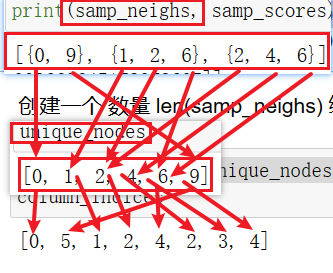
将二位列表中的所有元素在另一个列表中查找他们对应的索引，并保存为一个一维列表

In [54]:
row_indices = [i for i in range(len(samp_neighs)) for _ in range(len(samp_neighs[i]))]
row_indices

[0, 0, 1, 1, 1, 2, 2, 2]

将samp_neighs 中的所有子列表的索引按照子列表中元素的数量进行重复，并将这些索引组成一个一维列表 row_indices

In [55]:
mask[row_indices, column_indices] = 1
mask

tensor([[1., 0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1., 0.]])

将指定行列赋值为1

In [56]:
mask = mask.cuda()

将mask放入cuda

In [57]:
num_neigh = mask.sum(1, keepdim=True)
num_neigh

tensor([[2.],
        [3.],
        [3.]], device='cuda:0')

输出的是每个中心节点的过滤后的邻居数

In [58]:
mask = mask.div(num_neigh)
mask

tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000]], device='cuda:0')

mean-agg

In [59]:
embed_matrix = features(torch.LongTensor(unique_nodes_list).cuda())
embed_matrix

tensor([[0.1606, 0.2576, 0.0000, 0.0000, 0.0000, 0.0570, 0.0773, 0.0000, 0.0000,
         0.0000, 0.0637, 0.0000, 0.0000, 0.0277, 0.0000, 0.1578, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0000, 0.0000,
         0.1084, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0504, 0.0000, 0.0000, 0.0000, 0.1693, 0.0000, 0.0000, 0.0543,
         0.0000, 0.0586, 0.0310, 0.0000, 0.0715, 0.0694, 0.0565, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0777, 0.1792, 0.0270, 0.0000, 0.0148, 0.0000, 0.0000,
         0.0707, 0.0686, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0255, 0.0137, 0.1018, 0.1130, 0.0000,
         0.0000, 0.0000, 0.0082, 0.0000, 0.1112, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0642, 0.0000, 0.0000, 0.0517, 0.0000, 0.0000, 0.0000, 0.1323,
         0.0000, 0.0518, 0.3254, 0.0000, 0.0000],
        [0.0515, 0.0880, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0698, 0.0000, 0.0000, 0.1467,

从features中提取出所有unique_nodes的特征

In [60]:
to_feats = mask.mm(embed_matrix)
to_feats

tensor([[0.0803, 0.1456, 0.0515, 0.0222, 0.0155, 0.0342, 0.0387, 0.0452, 0.0000,
         0.0047, 0.0318, 0.0000, 0.0677, 0.0829, 0.0772, 0.0789, 0.0000, 0.0122,
         0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0440, 0.0000, 0.0000, 0.0000,
         0.0982, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0168, 0.0000, 0.0000, 0.0085, 0.0881, 0.0657, 0.0377, 0.0462,
         0.0397, 0.0299, 0.0131, 0.0000, 0.0911, 0.0907, 0.0188, 0.0000, 0.0291,
         0.0000, 0.0214, 0.0259, 0.0597, 0.0323, 0.0000, 0.0204, 0.0380, 0.0536,
         0.0236, 0.0401, 0.1085, 0.0000, 0.0000],
        [0.0172, 0.0293, 0.0000, 0.0000, 0.0085, 0.0317, 0.0657, 0.0377, 0.0281,
         0.0629, 0.0104, 0.0027, 0.0489, 0.0772, 0.0676, 0.0000, 0.0000, 0.0291,
         0.0751, 0.0727, 0.0015, 0.0000, 0.0386, 0.0181, 0.0202, 0.0380, 0.0536,
         0.0000, 0.0173, 0.1369, 0.0000, 0.0096]], device='cuda:0')

这将mask中的节点信息与节点的嵌入向量进行乘积，得到聚合后的节点特征的操作

In [61]:
import torch.nn.functional as F

to_feats = F.relu(to_feats)
to_feats

tensor([[0.0803, 0.1456, 0.0515, 0.0222, 0.0155, 0.0342, 0.0387, 0.0452, 0.0000,
         0.0047, 0.0318, 0.0000, 0.0677, 0.0829, 0.0772, 0.0789, 0.0000, 0.0122,
         0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0440, 0.0000, 0.0000, 0.0000,
         0.0982, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0168, 0.0000, 0.0000, 0.0085, 0.0881, 0.0657, 0.0377, 0.0462,
         0.0397, 0.0299, 0.0131, 0.0000, 0.0911, 0.0907, 0.0188, 0.0000, 0.0291,
         0.0000, 0.0214, 0.0259, 0.0597, 0.0323, 0.0000, 0.0204, 0.0380, 0.0536,
         0.0236, 0.0401, 0.1085, 0.0000, 0.0000],
        [0.0172, 0.0293, 0.0000, 0.0000, 0.0085, 0.0317, 0.0657, 0.0377, 0.0281,
         0.0629, 0.0104, 0.0027, 0.0489, 0.0772, 0.0676, 0.0000, 0.0000, 0.0291,
         0.0751, 0.0727, 0.0015, 0.0000, 0.0386, 0.0181, 0.0202, 0.0380, 0.0536,
         0.0000, 0.0173, 0.1369, 0.0000, 0.0096]], device='cuda:0')

公式(8) 得到了关系r_1下的聚合

In [ ]:
return to_feats, samp_scores

# Back to InterAgg

In [62]:
class IntraAgg(nn.Module):

    
	def __init__(self, features, feat_dim, cuda=False):
		"""
		Initialize the intra-relation aggregator
		:param features: the input node features or embeddings for all nodes
		:param feat_dim: the input dimension
		:param cuda: whether to use GPU
		"""
		super(IntraAgg, self).__init__()
		
        # 初始化IntraAgg模型时括号里输入的参数
        # 特征Embedding
		self.features = features
        # cpu计算
		self.cuda = cuda
        # 特征维度
		self.feat_dim = feat_dim

        # 变量名
	def forward(self, nodes, to_neighs_list, batch_scores, neigh_scores, sample_list):

		# filer neighbors under given relation
        # 给定关系下过滤后的邻居和分数
		samp_neighs, samp_scores = filter_neighs_ada_threshold(batch_scores, neigh_scores, to_neighs_list, sample_list)

		# find the unique nodes among batch nodes and the filtered neighbors
		unique_nodes_list = list(set.union(*samp_neighs))
		unique_nodes = {n: i for i, n in enumerate(unique_nodes_list)}

		# intra-relation aggregation only with sampled neighbors
		mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
		column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
		row_indices = [i for i in range(len(samp_neighs)) for _ in range(len(samp_neighs[i]))]
		mask[row_indices, column_indices] = 1
		if self.cuda:
			mask = mask.cuda()
		num_neigh = mask.sum(1, keepdim=True)
		mask = mask.div(num_neigh)
		if self.cuda:
			embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
		else:
			embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
		to_feats = mask.mm(embed_matrix)
		to_feats = F.relu(to_feats)
		return to_feats, samp_scores

In [64]:
intra_agg1 = IntraAgg(features, 32, cuda=True)
intra_agg2 = IntraAgg(features, 32, cuda=True)
intra_agg3 = IntraAgg(features, 32, cuda=True)

In [66]:
r1_feats, r1_scores = intra_agg1.forward(nodes, r1_list, center_scores, r1_scores, r1_sample_num_list)
r2_feats, r2_scores = intra_agg2.forward(nodes, r2_list, center_scores, r2_scores, r2_sample_num_list)
r3_feats, r3_scores = intra_agg3.forward(nodes, r3_list, center_scores, r3_scores, r3_sample_num_list)

TypeError: list indices must be integers or slices, not tuple

In [69]:
print(r1_feats)
print(r2_feats)
print(r3_feats)

tensor([[0.0803, 0.1456, 0.0515, 0.0222, 0.0155, 0.0342, 0.0387, 0.0452, 0.0000,
         0.0047, 0.0318, 0.0000, 0.0677, 0.0829, 0.0772, 0.0789, 0.0000, 0.0122,
         0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0440, 0.0000, 0.0000, 0.0000,
         0.0982, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0168, 0.0000, 0.0000, 0.0085, 0.0881, 0.0657, 0.0377, 0.0462,
         0.0397, 0.0299, 0.0131, 0.0000, 0.0911, 0.0907, 0.0188, 0.0000, 0.0291,
         0.0000, 0.0214, 0.0259, 0.0597, 0.0323, 0.0000, 0.0204, 0.0380, 0.0536,
         0.0236, 0.0401, 0.1085, 0.0000, 0.0000],
        [0.0172, 0.0293, 0.0000, 0.0000, 0.0085, 0.0317, 0.0657, 0.0377, 0.0281,
         0.0629, 0.0104, 0.0027, 0.0489, 0.0772, 0.0676, 0.0000, 0.0000, 0.0291,
         0.0751, 0.0727, 0.0015, 0.0000, 0.0386, 0.0181, 0.0202, 0.0380, 0.0536,
         0.0000, 0.0173, 0.1369, 0.0000, 0.0096]], device='cuda:0')
tensor([[0.0793, 0.1164, 0.0000, 0.0432, 0.0000, 0.0754, 0.0258, 0.0000, 0.0181,
         0.0000, 0.065

得到了每一种关系聚合

In [67]:
# concat the intra-aggregated embeddings from each relation
neigh_feats = torch.cat((r1_feats, r2_feats, r3_feats), dim=0)
neigh_feats

tensor([[0.0803, 0.1456, 0.0515, 0.0222, 0.0155, 0.0342, 0.0387, 0.0452, 0.0000,
         0.0047, 0.0318, 0.0000, 0.0677, 0.0829, 0.0772, 0.0789, 0.0000, 0.0122,
         0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0440, 0.0000, 0.0000, 0.0000,
         0.0982, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0168, 0.0000, 0.0000, 0.0085, 0.0881, 0.0657, 0.0377, 0.0462,
         0.0397, 0.0299, 0.0131, 0.0000, 0.0911, 0.0907, 0.0188, 0.0000, 0.0291,
         0.0000, 0.0214, 0.0259, 0.0597, 0.0323, 0.0000, 0.0204, 0.0380, 0.0536,
         0.0236, 0.0401, 0.1085, 0.0000, 0.0000],
        [0.0172, 0.0293, 0.0000, 0.0000, 0.0085, 0.0317, 0.0657, 0.0377, 0.0281,
         0.0629, 0.0104, 0.0027, 0.0489, 0.0772, 0.0676, 0.0000, 0.0000, 0.0291,
         0.0751, 0.0727, 0.0015, 0.0000, 0.0386, 0.0181, 0.0202, 0.0380, 0.0536,
         0.0000, 0.0173, 0.1369, 0.0000, 0.0096],
        [0.0793, 0.1164, 0.0000, 0.0432, 0.0000, 0.0754, 0.0258, 0.0000, 0.0181,
         0.0000, 0.0651, 0.0103, 0.0000,

意思是把所有r_1,r_2,r_3的特征以行重新组成一个邻居特征

In [71]:
# get features or embeddings for batch nodes
if True and isinstance(nodes, list):
    index = torch.LongTensor(nodes).cuda()

self_feats = features(index)
self_feats

tensor([[0.1606, 0.2576, 0.0000, 0.0000, 0.0000, 0.0570, 0.0773, 0.0000, 0.0000,
         0.0000, 0.0637, 0.0000, 0.0000, 0.0277, 0.0000, 0.1578, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0000, 0.0000,
         0.1084, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0504, 0.0000, 0.0000, 0.0000, 0.1693, 0.0000, 0.0000, 0.0543,
         0.0000, 0.0586, 0.0310, 0.0000, 0.0715, 0.0694, 0.0565, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0777, 0.1792, 0.0270, 0.0000, 0.0148, 0.0000, 0.0000,
         0.0707, 0.0686, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0255, 0.0137, 0.1018, 0.1130, 0.0000,
         0.0000, 0.0000, 0.0082, 0.0000, 0.1112, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0642, 0.0000, 0.0000, 0.0517, 0.0000, 0.0000, 0.0000, 0.1323,
         0.0000, 0.0518, 0.3254, 0.0000, 0.0000]], device='cuda:0')

提取出中心节点的features

In [73]:
# number of nodes in a batch
n = len(nodes)
n

3

batch中节点个数

In [ ]:
# Eq. (9) in the paper
if self.inter == 'Att':
    # 1) CARE-Att Inter-relation Aggregator
    combined, attention = att_inter_agg(len(self.adj_lists), self.leakyrelu, self_feats, neigh_feats, self.embed_dim,
                                        self.weight, self.a, n, self.dropout, self.training, self.cuda)
elif self.inter == 'Weight':
    # 2) CARE-Weight Inter-relation Aggregator
    combined = weight_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, self.alpha, n, self.cuda)
    gem_weights = F.softmax(torch.sum(self.alpha, dim=0), dim=0).tolist()
    if train_flag:
        print(f'Weights: {gem_weights}')
elif self.inter == 'Mean':
    # 3) CARE-Mean Inter-relation Aggregator
    combined = mean_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, n, self.cuda)
elif self.inter == 'GNN':
    # 4) CARE-GNN Inter-relation Aggregator
    combined = threshold_inter_agg(len(self.adj_lists), self_feats, neigh_feats, self.embed_dim, self.weight, self.thresholds, n, self.cuda)

In [ ]:
def threshold_inter_agg(num_relations, self_feats, neigh_feats, embed_dim, weight, threshold, n, cuda):
	"""
	CARE-GNN inter-relation aggregator
	Eq. (9) in the paper
	:param num_relations: number of relations in the graph
	:param self_feats: batch nodes features or embeddings
	:param neigh_feats: intra-relation aggregated neighbor embeddings for each relation
	:param embed_dim: the dimension of output embedding
	:param weight: parameter used to transform node embeddings before inter-relation aggregation
	:param threshold: the neighbor filtering thresholds used as aggregating weights
	:param n: number of nodes in a batch
	:param cuda: whether use GPU
	:return: inter-relation aggregated node embeddings
	"""

	# transform batch node embedding and neighbor embedding in each relation with weight parameter
	center_h = torch.mm(self_feats, weight)
	neigh_h = torch.mm(neigh_feats, weight)

	# initialize the final neighbor embedding
	if cuda:
		aggregated = torch.zeros(size=(n, embed_dim)).cuda()
	else:
		aggregated = torch.zeros(size=(n, embed_dim))

	# add weighted neighbor embeddings in each relation together
	for r in range(num_relations):
		aggregated += neigh_h[r * n:(r + 1) * n, :] * threshold[r]

	# sum aggregated neighbor embedding and batch node embedding
	# feed them to activation function
	combined = F.relu(center_h + aggregated)

	return combined

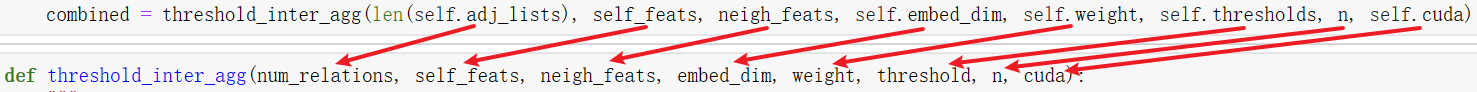

In [78]:
num_relations = len(adj_lists)
self_feats = self_feats
neigh_feats = neigh_feats
embed_dim = 64
feat_dim = 32
weight = nn.Parameter(torch.FloatTensor(feat_dim, embed_dim)).cuda()
threshold = [0.5, 0.5, 0.5]
n = n
cuda = True

In [79]:
center_h = torch.mm(self_feats, weight).cuda() # 3,32 X 32,64 
center_h

tensor([[3.2467e-18, 3.1529e-43, 5.8839e+31, 7.3428e-43, 2.7456e-18, 4.0638e-43,
         1.1953e-17, 5.9695e-43, 2.7456e-18, 1.2051e-43, 4.2545e-18, 2.2981e-43,
         4.1442e-18, 3.5873e-43, 5.4830e+18, 5.3389e-43, 6.1949e+29, 4.2740e-43,
         1.2399e-17, 6.1657e-43, 5.8027e-18, 4.3440e-43, 9.0392e-18, 4.4421e-43,
         7.3967e-18, 3.0548e-43, 1.5501e-17, 7.3428e-43, 1.0113e-17, 6.6982e-43,
         8.6859e+29, 5.5071e-43, 9.1726e-18, 4.1619e-43, 1.0642e-17, 5.3670e-43,
         2.5508e-18, 2.2561e-43, 9.9463e-18, 4.6103e-43, 9.4235e+02, 3.8396e-43,
         1.2093e-17, 5.3950e-43, 9.9492e-44, 1.7937e-43, 3.1678e+18, 6.6842e-43,
         5.4371e+31, 3.9797e-43, 6.6613e+32, 6.8664e-43, 2.3246e+32, 5.1848e-43,
         9.0402e-18, 4.5402e-43, 4.6578e-18, 4.0778e-43, 8.7136e+24, 5.2689e-43,
         6.0583e-18, 5.2829e-43, 1.6971e+32, 5.4931e-43],
        [4.3212e-18, 4.6103e-43, 2.8562e+32, 1.9548e-42, 5.7762e-18, 4.6663e-43,
         6.2906e-18, 3.7975e-43, 2.4666e-18, 1.6395

中心节点embedding x (init)weight

In [83]:
neigh_h = torch.mm(neigh_feats, weight)
print(neigh_h.shape)

torch.Size([9, 64])


邻居节点embedding x (init)weight

In [82]:
aggregated = torch.zeros(size=(n, embed_dim)).cuda() # 3 x 32
aggregated

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [85]:
for r in range(num_relations):
    aggregated += neigh_h[r * n:(r + 1) * n, :] * threshold[r]
aggregated

tensor([[7.1805e-18, 5.8574e-43, 9.3241e+31, 1.1743e-42, 4.4383e+02, 5.7453e-43,
         9.2073e+28, 7.0766e-43, 5.5689e-18, 3.3911e-43, 4.1943e+31, 5.0166e-43,
         6.7507e-18, 5.2689e-43, 4.6760e+18, 8.4498e-43, 3.6553e+29, 6.1937e-43,
         1.4263e-17, 8.9543e-43, 1.0081e-17, 6.9925e-43, 1.2755e-17, 7.7772e-43,
         4.8035e+30, 4.9326e-43, 1.0378e+18, 9.8511e-43, 1.5001e+18, 8.9823e-43,
         7.7737e+29, 7.9033e-43, 9.8449e-18, 5.2969e-43, 1.5632e-17, 8.4078e-43,
         5.7148e-18, 4.0498e-43, 4.8035e+30, 6.5721e-43, 9.8480e+02, 5.4651e-43,
         6.8869e+29, 8.7441e-43, 3.3919e-18, 4.5122e-43, 4.1272e+18, 9.2486e-43,
         3.2082e+31, 4.9466e-43, 8.5401e+32, 8.9823e-43, 2.4293e+32, 8.4779e-43,
         3.8554e+31, 7.3568e-43, 5.4549e+02, 4.6523e-43, 2.0132e+29, 7.0766e-43,
         1.0108e+02, 7.4129e-43, 1.3531e+32, 7.7912e-43],
        [5.2358e-18, 5.8714e-43, 2.1184e+32, 2.6330e-42, 7.0235e+02, 6.3339e-43,
         5.4368e+29, 6.8804e-43, 3.2039e-18, 3.7695

公式(9)

In [86]:
combined = F.relu(center_h + aggregated)
combined

tensor([[1.0427e-17, 9.0103e-43, 1.5208e+32, 1.9086e-42, 4.4383e+02, 9.8091e-43,
         9.2073e+28, 1.3046e-42, 8.3144e-18, 4.5963e-43, 4.1943e+31, 7.3148e-43,
         1.0895e-17, 8.8562e-43, 1.0159e+19, 1.3789e-42, 9.8502e+29, 1.0468e-42,
         2.6662e-17, 1.5120e-42, 1.5884e-17, 1.1337e-42, 2.1794e-17, 1.2219e-42,
         4.8035e+30, 7.9874e-43, 1.0378e+18, 1.7194e-42, 1.5001e+18, 1.5681e-42,
         1.6460e+30, 1.3410e-42, 1.9017e-17, 9.4588e-43, 2.6274e-17, 1.3775e-42,
         8.2656e-18, 6.3058e-43, 4.8035e+30, 1.1182e-42, 1.9271e+03, 9.3046e-43,
         6.8869e+29, 1.4139e-42, 3.3919e-18, 6.3058e-43, 7.2950e+18, 1.5933e-42,
         8.6454e+31, 8.9263e-43, 1.5201e+33, 1.5849e-42, 4.7539e+32, 1.3663e-42,
         3.8554e+31, 1.1897e-42, 5.4549e+02, 8.7301e-43, 2.0133e+29, 1.2345e-42,
         1.0108e+02, 1.2696e-42, 3.0502e+32, 1.3284e-42],
        [9.5569e-18, 1.0482e-42, 4.9746e+32, 4.5879e-42, 7.0235e+02, 1.1000e-42,
         5.4368e+29, 1.0678e-42, 5.6704e-18, 5.4090

# InterAgg.forward()

In [ ]:
if self.RL and train_flag:
    relation_scores, rewards, thresholds, stop_flag = RLModule([r1_scores, r2_scores, r3_scores],
                                                               self.relation_score_log, labels, self.thresholds,
                                                               self.batch_num, self.step_size)
    self.thresholds = thresholds
    self.RL = stop_flag
    self.relation_score_log.append(relation_scores)
    self.thresholds_log.append(self.thresholds)

# RLModule

In [ ]:
def RLModule(scores, scores_log, labels, thresholds, batch_num, step_size):
	"""
	The reinforcement learning module.
	It updates the neighbor filtering threshold for each relation based
	on the average neighbor distances between two consecutive epochs.
	:param scores: the neighbor nodes label-aware scores for each relation
	:param scores_log: a list stores the relation average distances for each batch
	:param labels: the batch node labels used to select positive nodes
	:param thresholds: the current neighbor filtering thresholds for each relation
	:param batch_num: numbers batches in an epoch
	:param step_size: the RL action step size
	:return relation_scores: the relation average distances for current batch
	:return rewards: the reward for given thresholds in current epoch
	:return new_thresholds: the new filtering thresholds updated according to the rewards
	:return stop_flag: the RL terminal condition flag
	"""

	relation_scores = []
	stop_flag = True

	# only compute the average neighbor distances for positive nodes
	pos_index = (labels == 1).nonzero().tolist()
	pos_index = [i[0] for i in pos_index]

	# compute average neighbor distances for each relation
	for score in scores:
		pos_scores = itemgetter(*pos_index)(score)
		neigh_count = sum([1 if isinstance(i, float) else len(i) for i in pos_scores])
		pos_sum = [i if isinstance(i, float) else sum(i) for i in pos_scores]
		relation_scores.append(sum(pos_sum) / neigh_count)

	if len(scores_log) % batch_num != 0 or len(scores_log) < 2 * batch_num:
		# do not call RL module within the epoch or within the first two epochs
		rewards = [0, 0, 0]
		new_thresholds = thresholds
	else:
		# update thresholds according to average scores in last epoch
		# Eq.(5) in the paper
		previous_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-2 * batch_num:-batch_num])]
		current_epoch_scores = [sum(s) / batch_num for s in zip(*scores_log[-batch_num:])]

		# compute reward for each relation and update the thresholds according to reward
		# Eq. (6) in the paper
		rewards = [1 if previous_epoch_scores[i] - s >= 0 else -1 for i, s in enumerate(current_epoch_scores)]
		new_thresholds = [thresholds[i] + step_size if r == 1 else thresholds[i] - step_size for i, r in enumerate(rewards)]

		# avoid overflow
		new_thresholds = [0.999 if i > 1 else i for i in new_thresholds]
		new_thresholds = [0.001 if i < 0 else i for i in new_thresholds]

		print(f'epoch scores: {current_epoch_scores}')
		print(f'rewards: {rewards}')
		print(f'thresholds: {new_thresholds}')

	# TODO: add terminal condition

	return relation_scores, rewards, new_thresholds, stop_flag

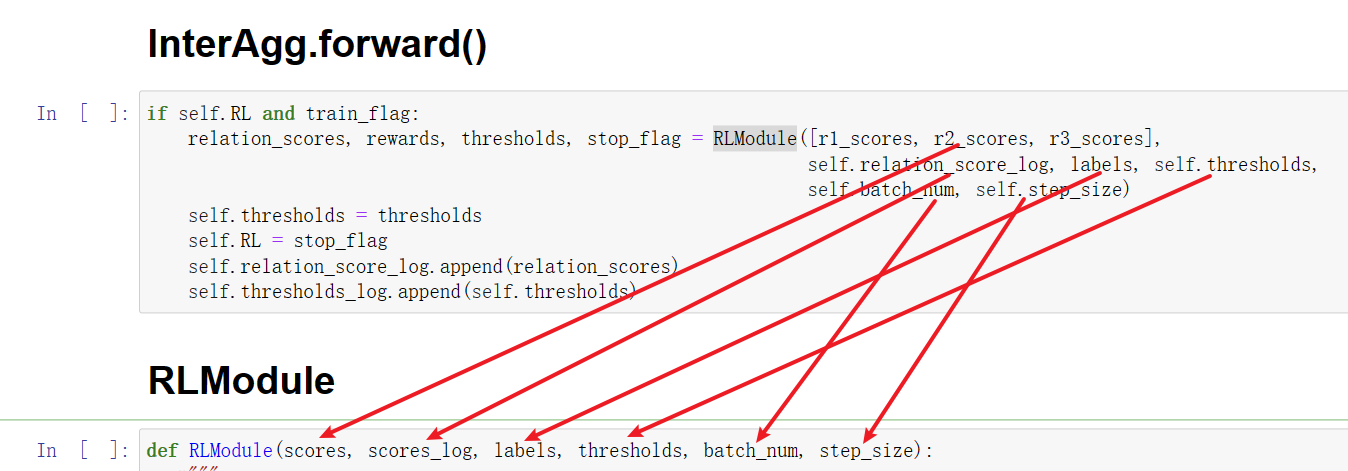

In [103]:
scores = [r1_scores, r2_scores, r3_scores]
scores_log = []
# labels = np.array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1])
threshold = [0.5, 0.5, 0.5]
batch_num = 0
step_size = 0.02

In [104]:
relation_scores = []
stop_flag = True

In [105]:
# only compute the average neighbor distances for positive nodes
# pos_index = (labels == 1).nonzero().tolist()
labels = torch.randint(low=0, high=2, size=(10,), dtype=torch.int)
labels

tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0], dtype=torch.int32)

In [106]:
pos_index = (labels == 1).nonzero().tolist()
pos_index = [i[0] for i in pos_index]
pos_index

[1, 3, 5, 7, 8]